In [1]:
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()

import mdtraj as md
import numpy as np
import os

import MDAnalysis as mda
import nglview as nv

import pandas as pd

import gmxapi as gmx

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import re, shutil, tempfile

def sed_inplace(filename, pattern, repl):
    '''
    Perform the pure-Python equivalent of in-place `sed` substitution: e.g.,
    `sed -i -e 's/'${pattern}'/'${repl}' "${filename}"`.
    '''
    # For efficiency, precompile the passed regular expression.
    pattern_compiled = re.compile(pattern)

    # For portability, NamedTemporaryFile() defaults to mode "w+b" (i.e., binary
    # writing with updating). This is usually a good thing. In this case,
    # however, binary writing imposes non-trivial encoding constraints trivially
    # resolved by switching to text writing. Let's do that.
    with tempfile.NamedTemporaryFile(mode='w', delete=False) as tmp_file:
        with open(filename) as src_file:
            for line in src_file:
                tmp_file.write(pattern_compiled.sub(repl, line))

    # Overwrite the original file with the munged temporary file in a
    # manner preserving file attributes (e.g., permissions).
    shutil.copystat(filename, tmp_file.name)
    shutil.move(tmp_file.name, filename)

In [4]:
from manuscript import *

<Figure size 432x288 with 0 Axes>

In [5]:
sns.set(style="ticks",context='paper',font_scale=2)

## PNU Optimization

In [6]:
qm_mm_data = pd.read_csv('data/dihedral_qm_mm_qou.csv',sep=';')

In [7]:
qm_mm_data = qm_mm_data.sort_values(by=['Dihedral'])

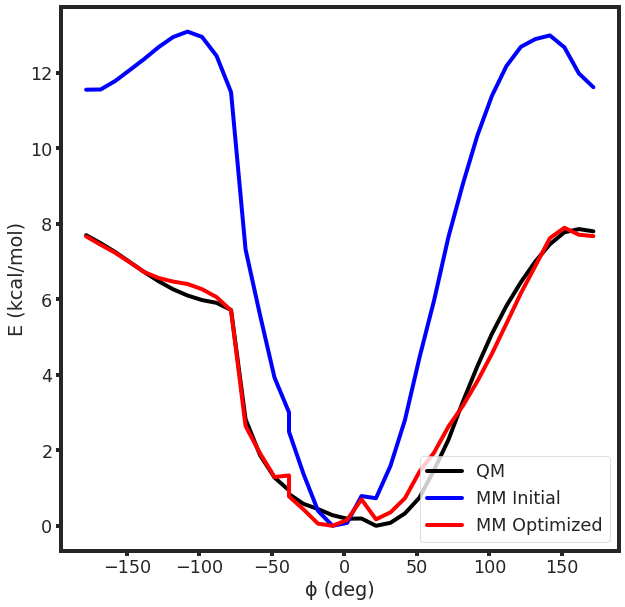

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(qm_mm_data['Dihedral'], qm_mm_data['QM'], color='black',label='QM',linewidth=4)
ax.plot(qm_mm_data['Dihedral'], qm_mm_data['Old-MM'], color='blue',label='MM Initial',linewidth=4)
ax.plot(qm_mm_data['Dihedral'], qm_mm_data['New-MM'], color='red',label='MM Optimized',linewidth=4)
ax.set_xlabel('ϕ (deg)')
#ax.set_xlim(0,360)

ax.set_ylabel('E (kcal/mol)')

plt.legend(loc='lower right')
set_axis_boarder(ax)
plt.savefig('Figures/pnu_dihedral.pdf',bbox_inches = 'tight', pad_inches=0.1, transparent=False)

# Prepare System

## Load init pulling trajectory

In [77]:
location = '../topology/PNU_parameters/CG/PMF/'

In [5]:
u = mda.Universe(location +'eq.gro',
                 location +'pulling.xtc')

/nethome/yzhuang/mdanalysis/package/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: D
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/nethome/yzhuang/mdanalysis/package/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: G
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


In [6]:
pnu_ag = u.select_atoms('resname pnu')

In [7]:
from MDAnalysis.analysis import distances

In [8]:
pnu_loc = []
for ts in u.trajectory:
    pnu_loc.append(np.mean(pnu_ag.positions,axis=0)[2])

0.0005 nm / ps

0.5 A / frame

In [9]:
u.trajectory.dt

100.0

<AxesSubplot:>

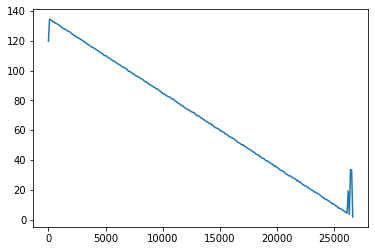

In [10]:
sns.lineplot(x=np.arange(u.trajectory.n_frames) * u.trajectory.dt,
             y=pnu_loc)

In [ ]:
l = np.arange(-6.5,6.5,0.05)
    

def grouped(iterable, n):
    "s -> (s0,s1,s2,...sn-1), (sn,sn+1,sn+2,...s2n-1), (s2n,s2n+1,s2n+2,...s3n-1), ..."
    return zip(*[iter(iterable)]*n)

i = 0
with open(location + 'PRODUCTION/echo.sh', 'w') as f:

    for a, b, c, d in grouped(l, 4):
    #    print(i)
        f.write('"{:.2f} {:.2f} {:.2f} {:.2f}" \t'.format(a, b, c, d))
        print(i)
        i = i +1

In [15]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [22]:
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(np.arange(u.trajectory.n_frames).reshape((-1, 1)), np.asarray(pnu_loc))

print('intercept:', regr.intercept_)
print('slope:', regr.coef_)

intercept: 134.2128736345409
slope: [-0.49284421]


In [24]:
for ts, dist, act_dist in zip(u.trajectory[0::1], pnu_loc[0::1], np.arange(-6.5,6.5,0.05)):
    sub_dir = location + 'PRODUCTION/' + '{:.2f}'.format(act_dist)
    os.mkdir(sub_dir)
    shutil.copy(location + 'PRODUCTION/pulling.mdp', sub_dir)
    sed_inplace(sub_dir + '/pulling.mdp', r'INIT_POS', '{:.2f}'.format(act_dist))
    shutil.copy(location + 'PRODUCTION/eq.mdp', sub_dir)
    sed_inplace(sub_dir + '/eq.mdp', r'INIT_POS', '{:.2f}'.format(act_dist))
    u.atoms.write(sub_dir + '/init.pdb')

/nethome/yzhuang/mdanalysis/package/MDAnalysis/coordinates/PDB.py:1058: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/nethome/yzhuang/mdanalysis/package/MDAnalysis/coordinates/PDB.py:1058: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/nethome/yzhuang/mdanalysis/package/MDAnalysis/coordinates/PDB.py:1058: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  warnings.warn("Found no information for attr: '{}'"
/nethome/yzhuang/mdanalysis/package/MDAnalysis/coordinates/PDB.py:1058: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  warnings.warn("Found no information for attr: '{}'"
/nethome/yzhuang/mdanalysis/package/MDAnalysis/coordinates/PDB.py:1058: UserWarning: Found no information for attr: 'record_types' Using default value of 'ATOM'


In [ ]:
for act_dist in np.arange(-6.5,6.5,0.05):
    sub_dir = location + 'PRODUCTION/' + '{:.2f}'.format(act_dist)
    gmx_run = gmx.commandline_operation('gmx',
                  arguments=['grompp', '-maxwarn', '-1'],
                  input_files={
                        '-f': sub_dir + '/eq.mdp',
                        '-c': sub_dir + '/init.pdb',
                        '-r': sub_dir + '/init.pdb',
                        '-p': location + '/system.top',
                        '-n': location + '/index.ndx',

                  },
                  output_files={
                        '-o': sub_dir + '/eq.tpr'
                  }
                 )
    gmx_run.run()


In [81]:
for act_dist in np.arange(-6.5,6.5,0.05):
    sub_dir = location + 'PRODUCTION/' + '{:.2f}'.format(act_dist)
    gmx_run = gmx.commandline_operation('gmx',
                  arguments=['grompp', '-maxwarn', '-1'],
                  input_files={
                        '-f': sub_dir + '/pulling.mdp',
                        '-c': sub_dir + '/eq.gro',
                        '-r': sub_dir + '/eq.gro',
                        '-p': location + '/system.top',
                        '-n': location + '/index.ndx',

                  },
                  output_files={
                        '-o': sub_dir + '/pulling.tpr'
                  }
                 )
    gmx_run.run()

In [85]:
location = '../topology/PNU_parameters/AA/PMF/'

In [86]:
u = mda.Universe(location +'eq.gro',
                 location +'pulling.xtc')

/nethome/yzhuang/mdanalysis/package/MDAnalysis/coordinates/XDR.py:214: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


In [87]:
pnu_ag = u.select_atoms('resname PNU')

In [88]:
from MDAnalysis.analysis import distances

In [89]:
pnu_loc = []
for ts in u.trajectory:
    pnu_loc.append(np.mean(pnu_ag.positions,axis=0)[2])

0.0005 nm / ps

0.5 A / frame

<AxesSubplot:>

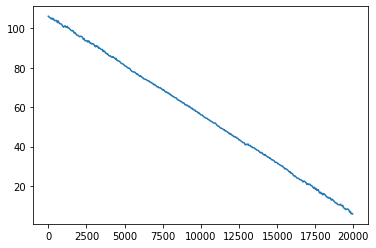

In [90]:
sns.lineplot(x=np.arange(u.trajectory.n_frames) * u.trajectory.dt,
             y=pnu_loc)

In [91]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [92]:
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(np.arange(u.trajectory.n_frames).reshape((-1, 1)), np.asarray(pnu_loc))

print('intercept:', regr.intercept_)
print('slope:', regr.coef_)

intercept: 106.44762150800733
slope: [-0.25082389]


In [93]:
for ts, dist, act_dist in zip(u.trajectory[0::2], pnu_loc[0::2], np.arange(-4.7,4.7,0.05)):
    sub_dir = location + 'PRODUCTION/' + '{:.2f}'.format(act_dist)
    os.mkdir(sub_dir)
    shutil.copy(location + 'PRODUCTION/pulling.mdp', sub_dir)
    sed_inplace(sub_dir + '/pulling.mdp', r'INIT_POS', '{:.2f}'.format(act_dist))
    shutil.copy(location + 'PRODUCTION/eq.mdp', sub_dir)
    sed_inplace(sub_dir + '/eq.mdp', r'INIT_POS', '{:.2f}'.format(act_dist))
    u.atoms.write(sub_dir + '/init.pdb')

/nethome/yzhuang/mdanalysis/package/MDAnalysis/coordinates/PDB.py:1058: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/nethome/yzhuang/mdanalysis/package/MDAnalysis/coordinates/PDB.py:1058: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
/nethome/yzhuang/mdanalysis/package/MDAnalysis/coordinates/PDB.py:1058: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  warnings.warn("Found no information for attr: '{}'"
/nethome/yzhuang/mdanalysis/package/MDAnalysis/coordinates/PDB.py:1058: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  warnings.warn("Found no information for attr: '{}'"
/nethome/yzhuang/mdanalysis/package/MDAnalysis/coordinates/PDB.py:1058: UserWarning: Found no information for attr: 'record_types' Using default value of 'ATOM'


In [101]:
for ts, dist, act_dist in zip(u.trajectory[0::2], pnu_loc[0::2], np.arange(-4.7,4.7,0.05)):
    sub_dir = location + 'PRODUCTION/' + '{:.2f}'.format(act_dist)
    os.mkdir(sub_dir)
    shutil.copy(location + 'PRODUCTION/pulling.mdp', sub_dir)
    sed_inplace(sub_dir + '/pulling.mdp', r'INIT_POS', '{:.2f}'.format(act_dist))
    shutil.copy(location + 'PRODUCTION/eq.mdp', sub_dir)
    sed_inplace(sub_dir + '/eq.mdp', r'INIT_POS', '{:.2f}'.format(act_dist))
    u.atoms.write(sub_dir + '/init.pdb')

In [102]:
for act_dist in np.arange(-4.7,4.7,0.05):
    sub_dir = location + 'PRODUCTION/' + '{:.2f}'.format(act_dist)
    gmx_run = gmx.commandline_operation('gmx',
                  arguments=['grompp', '-maxwarn', '-1'],
                  input_files={
                        '-f': sub_dir + '/eq.mdp',
                        '-c': sub_dir + '/init.pdb',
                        '-r': sub_dir + '/init.pdb',
                        '-p': location + '/topol.top',
                        '-n': location + '/index.ndx',

                  },
                  output_files={
                        '-o': sub_dir + '/eq.tpr'
                  }
                 )
    gmx_run.run()


In [103]:
for act_dist in np.arange(-4.7,4.7,0.05):
    sub_dir = location + 'PRODUCTION/' + '{:.2f}'.format(act_dist)
    gmx_run = gmx.commandline_operation('gmx',
                  arguments=['grompp', '-maxwarn', '-1'],
                  input_files={
                        '-f': sub_dir + '/pulling.mdp',
                        '-c': sub_dir + '/eq.gro',
                        '-r': sub_dir + '/eq.gro',
                        '-p': location + 'topol.top',
                        '-n': location + 'index.ndx',

                  },
                  output_files={
                        '-o': sub_dir + '/pulling.tpr'
                  }
                 )
    gmx_run.run()
    print(gmx_run.output.erroroutput.result())

## Analaysis

In [10]:
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()

import mdtraj as md
import numpy as np
import os

import MDAnalysis as mda
import nglview as nv

import pandas as pd

import gmxapi as gmx

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
class USProfile_XVG(object):
    def __init__(self, location):
        self.filename = location + 'profile.xvg'
        self.md_name = location.split('/')[-3]
        self.ion_type = location.split('/')[-2].split('_')[-1]
        self.read()
        
    def read(self):
        self.profile = pd.read_table(self.filename,
                                 header=None,
                                 names=['coord','energy'],
                                 sep='\s+',
                                 error_bad_lines=False,
                                 skiprows=17)
        self.profile.coord = self.profile.coord.apply(float)
        self.profile.coord = self.profile.coord * 10

        self.profile.energy = self.profile.energy.apply(float)

In [13]:
class UShisto_XVG(object):
    def __init__(self, walker, location):
        self.filename = location + 'histo.xvg'
        self.md_name = location.split('/')[-3]
        self.ion_type = location.split('/')[-2].split('_')[-1]
        self.read()
        
    def read(self):
        self.profile = pd.read_table(self.filename,
                                 header=None,
                                 names=['Time','Position'],
                                 sep='\s+',
                                 error_bad_lines=False,
                                 skiprows=17)
        self.profile.Position = self.profile.Position.apply(float)
        self.profile.Time = self.profile.Time.apply(float)

In [14]:
class USbsResult_XVG(object):
    def __init__(self, location):
        self.filename = location + 'bsResult.xvg'
        self.md_name = location.split('/')[-3]
        self.ion_type = location.split('/')[-2].split('_')[-1]
        self.read()
        
    def read(self):
        self.profile = pd.read_table(self.filename,
                                 header=None,
                                 names=['coord','energy', 'energy_std'],
                                 sep='\s+',
                                 error_bad_lines=False,
                                 skiprows=18)
        self.profile.coord = self.profile.coord.apply(float)
        self.profile.coord = self.profile.coord * 10

        self.profile.energy = self.profile.energy.apply(float)
        self.profile.energy_std = self.profile.energy_std.apply(float)

In [15]:
class USbsProfs_XVG(object):
    def __init__(self, walker, location):
        self.filename = location + 'profile.xvg'
        self.md_name = location.split('/')[-3]
        self.ion_type = location.split('/')[-2].split('_')[-1]
        self.read()
        
    def read(self):
        self.profile = pd.read_table(self.filename,
                                 header=None,
                                 names=['Time','Position'],
                                 sep='\s+',
                                 error_bad_lines=False,
                                 skiprows=17)
        self.profile.Position = self.profile.Position.apply(float)
        self.profile.Time = self.profile.Time.apply(float)

In [16]:
location = '../topology/PNU_parameters/CG/PMF/PRODUCTION/'

In [17]:
location = '../topology/PNU_parameters/AA/PMF/PRODUCTION/'

In [198]:
tpr_ensemble = []
pullx_ensemble = []

for directory in os.walk(location):
    if 'pulling_pullx.xvg' in directory[2]:
        tpr_ensemble.append(directory[0] + '/pulling.tpr')
        pullx_ensemble.append(directory[0] + '/pulling_pullx.xvg')
    
with open(location + 'tpr-files.dat', 'w') as tpr_dat_file:
    tpr_dat_file.write("\n".join(tpr_ensemble))
with open(location + 'pullx-files.dat', 'w') as pullx_dat_file:
    pullx_dat_file.write("\n".join(pullx_ensemble))

In [163]:
for pullx in pullx_ensemble:
    with open(pullx, 'r') as f:
        lines = f.readlines(-1)
        print(pullx)
        print(lines[-2:])


/nethome/yzhuang/2020100800_alpha7_nachrs/PNU_parameters/AA/PMF/PRODUCTION/-4.55/pulling_pullx.xvg
['5066.5000\t-4.53251\n', '5066.6000\t-4.53089\n']
/nethome/yzhuang/2020100800_alpha7_nachrs/PNU_parameters/AA/PMF/PRODUCTION/-2.45/pulling_pullx.xvg
['4991.5000\t-2.45872\n', '4991.6000\t-2.45634\n']
/nethome/yzhuang/2020100800_alpha7_nachrs/PNU_parameters/AA/PMF/PRODUCTION/-4.15/pulling_pullx.xvg
['5022.7000\t-4.13825\n', '5022.8000\t-4.14496\n']
/nethome/yzhuang/2020100800_alpha7_nachrs/PNU_parameters/AA/PMF/PRODUCTION/-1.90/pulling_pullx.xvg
['5102.7000\t-1.90442\n', '5102.8000\t-1.90762\n']
/nethome/yzhuang/2020100800_alpha7_nachrs/PNU_parameters/AA/PMF/PRODUCTION/2.50/pulling_pullx.xvg
['5051.3000\t2.49225\n', '5051.4000\t2.48509\n']
/nethome/yzhuang/2020100800_alpha7_nachrs/PNU_parameters/AA/PMF/PRODUCTION/3.95/pulling_pullx.xvg
['5050.5000\t3.92448\n', '5050.6000\t3.92536\n']
/nethome/yzhuang/2020100800_alpha7_nachrs/PNU_parameters/AA/PMF/PRODUCTION/0.55/pulling_pullx.xvg
['4956.3

In [18]:
import gmxapi as gmx

In [19]:
import glob

In [24]:
try:
    for f in glob.glob(location + '/#*'):
        os.remove(f)
except:
    pass

In [20]:
cg_location = '../topology/PNU_parameters/CG/PMF/PRODUCTION/'

In [ ]:
wham_bin = 500
wham_temp = 300
wham_b = 50
wham_nbootstrap = 100
#wham_zprof0 = 0
#wham_e = 2500

wham = gmx.commandline_operation('gmx',
                                 arguments=['wham', '-cycl','-sym'],
                                 input_files={
                                              '-ix': cg_location + 'pullx-files.dat',
                                              '-it': cg_location + 'tpr-files.dat',
                                              '-bins': str(wham_bin),
                                              '-temp': str(wham_temp),
                                              '-unit': 'kCal',
                                              '-b': str(wham_b),
                                             # '-e': str(wham_e),
                                              '-nBootstrap': str(wham_nbootstrap),
#                                              '-zprof0': str(wham_zprof0),
                                             # '-min': str(wham_min),
                                             # '-max': str(wham_max)
                                 },
                                 output_files={'-o': cg_location + 'profile.xvg',
                                             '-hist': cg_location + 'histo.xvg',
                                             '-bsres': cg_location + 'bsResult.xvg',
                                             '-bsprof': cg_location + 'bsProfs.xvg'})
wham.run()
if wham.output.erroroutput.result() != "":
    print(wham.output.erroroutput.result())

In [21]:
cg_profile = USbsResult_XVG(cg_location)

In [22]:
aa_location = '../topology/PNU_parameters/AA/PMF/PRODUCTION/'

In [ ]:
wham_bin = 500
wham_temp = 300
wham_b = 50
wham_nbootstrap = 100
#wham_zprof0 = 0
#wham_e = 2500
#wham_min = - 4.4
#wham_max = 4.4


wham = gmx.commandline_operation('gmx',
                                 arguments=['wham', '-cycl','-sym'],
                                 input_files={
                                              '-ix': aa_location + 'pullx-files.dat',
                                              '-it': aa_location + 'tpr-files.dat',
                                              '-bins': str(wham_bin),
                                              '-temp': str(wham_temp),
                                              '-unit': 'kCal',
                                              '-b': str(wham_b),
#                                              '-e': str(wham_e),
                                              '-nBootstrap': str(wham_nbootstrap),
                                              '-zprof0': str(wham_zprof0),
#                                              '-min': str(wham_min),
#                                              '-max': str(wham_max)
                                 },
                                 output_files={'-o': aa_location + 'profile.xvg',
                                             '-hist': aa_location + 'histo.xvg',
                                             '-bsres': aa_location + 'bsResult.xvg',
                                             '-bsprof': aa_location + 'bsProfs.xvg'})
wham.run()
if wham.output.erroroutput.result() != "":
    print(wham.output.erroroutput.result())

In [23]:
aa_profile = USbsResult_XVG(aa_location)

In [24]:
def plot_us_pmf(us_file, xdata, ax, skip=10, ylim=None, color=None):
    if 'energy_std' in us_file.profile.keys():
#        l = ax.errorbar(us_file.profile[xdata][::skip],
#                    us_file.profile['coord'][::skip],
#                    xerr = us_file.profile['energy_std'][::skip],errorevery=5,capsize=5)
#        l[0].set_linewidth(3)
#        l[0].set_marker(".")
#        l[0].set_markerfacecolor('white')
        ax.fill_betweenx(us_file.profile['coord'][::skip],
                        us_file.profile[xdata][::skip] - us_file.profile['energy_std'][::skip],
                        us_file.profile[xdata][::skip] + us_file.profile['energy_std'][::skip],
                        alpha=0.4, color=color)
        l = ax.plot(us_file.profile[xdata][::skip],
                    us_file.profile['coord'][::skip],color=color,linewidth=4)
#        l.set_linewidth(2)
#        l[0].set_marker("*")
#        l[0].set_markerfacecolor('white')
    else:
        l = ax.plot(us_file.profile[xdata][::skip],
                    us_file.profile['coord'][::skip],color=color)
        l[0].set_linewidth(2)
        l[0].set_marker("*")
        l[0].set_markerfacecolor('white')
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.set_xlabel(xdata + ' (kJ/mol or \\)')
    ax.yaxis.set_tick_params(width=4)
    ax.xaxis.set_tick_params(width=4)

    ax.set_ylabel('Coord along axis(Å)')
    return l
#    l[0].set_color(palette[us_file.md_name])

In [25]:
palette={'NACHRA7_NOPNU_EPJ_POPC':'#e66101',
         'NACHRA7_EPJ_POPC':'#fdb863',
         'NACHRA7_BGT_POPC':'#5e3c99'}

In [26]:
def plot_auxilary(ax, ion=False, system=False):
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.set_ylabel('Annotations')  # we already handled the x-label with ax1
    ax2.tick_params(axis='y',direction='in')
    ax2.set_ylim(ax.get_ylim())

    ax2.spines['top'].set_linewidth(4)
    ax2.spines['right'].set_linewidth(4)
    ax2.yaxis.set_tick_params(width=4)
    ax2.set_yticks([2,13,35])
    ax2.set_yticklabels(['Pore', 'Binding \nSite', 'Lipid'])

    if ion:
        bar_list = []
        bar_list.append(plt.Line2D([0], [0],color='black',linewidth=1,marker='*',markerfacecolor='white'))
        bar_list.append(plt.Line2D([0], [0],color='black',linewidth=1,marker='h',markerfacecolor='white'))
        bar_list.append(plt.Line2D([0], [0],color='black',linewidth=1,marker='x',markerfacecolor='white'))
        bar_list.append(plt.Line2D([0], [0],color='black',linewidth=1,marker='v',markerfacecolor='white'))
        bar_list.append(plt.Line2D([0], [0],color='black',linewidth=1,marker='D',markerfacecolor='white'))
        ion_list = ['SOD','CAL','CAM','CLA','POT']
        l = plt.legend(bar_list, ion_list, loc=3, ncol = 1, prop={'size':15})
        l.draw_frame(False)

        ax = plt.gca().add_artist(l)
    if system: 
        bar_list_2 = []
        bar_list_2.append(plt.Line2D([0], [0],color='#e66101',linewidth=3))
        bar_list_2.append(plt.Line2D([0], [0],color='#fdb863',linewidth=3))
        bar_list_2.append(plt.Line2D([0], [0],color='#5e3c99',linewidth=3))
        sim_list = ['EPJ_PNU','EPJ','BGT']
        l_2 = plt.legend(bar_list_2, sim_list, loc=1, ncol = 3, prop={'size':15})
        l_2.draw_frame(False)


In [27]:
aa_profile.profile.energy = aa_profile.profile.energy / 4.184 

In [28]:
aa_profile.profile.energy_std = aa_profile.profile.energy_std / 4.184 

In [35]:
aa_profile.profile.energy = aa_profile.profile.energy + 3.5

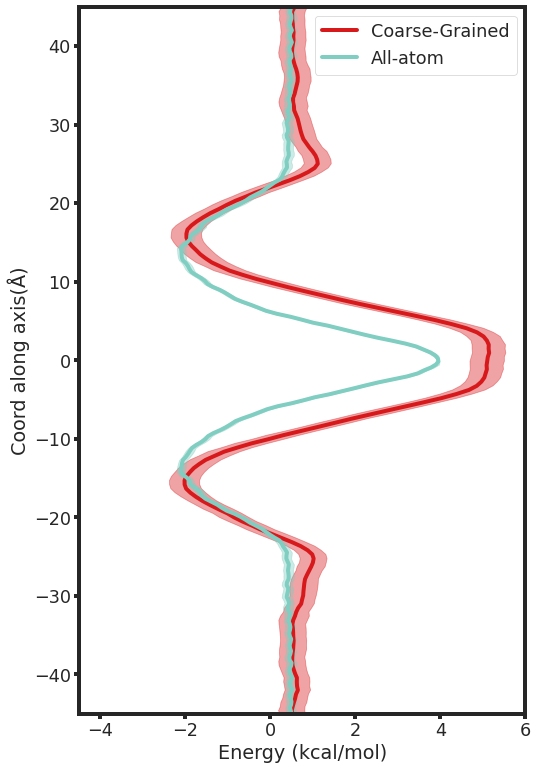

In [36]:
fig, ax = plt.subplots(figsize=(8,13))
l_cg = plot_us_pmf(cg_profile, 'energy', ax, skip=2, color='#d7191c')
l_aa = plot_us_pmf(aa_profile, 'energy', ax, skip=2, color='#80cdc1')

#plot_auxilary(ax)
plt.locator_params(axis='x', nbins=9)
ax.set_ylim(-45,45)
ax.set_xlim(-4.5,6)
ax.legend(['Coarse-Grained', 'All-atom'])
ax.set_xlabel('Energy (kcal/mol)')

set_axis_boarder(ax)
plt.savefig('Figures/PNU_PMF_membrane.pdf',bbox_inches = 'tight', pad_inches=0.1, transparent=False)